#  EDA: Suitable Countries for Bicycle Rental Business

Since the beginning of 2020, the biking industry had an influx of new customers due to the restriction of public transportation caused by the pandemic. There was a shortage in the supply of bicycles as millions of people saw the benefits of having a bike as their main way of transport. Such benefits includes biking as a form of exercise which helps alleviate the strain caused by having a sedentary lifestyle and it also helps reduce carbon emmision which could contribute to climate change. But as I got deeper to understanding the industry, I noticed that biking as the main form of transportation is not prevalent in my country, the Philippines. What could have caused this discrepency between countries and which countries are more suitable for a bicycle rental business, let us find out!

# Objectives:
1. Find out why biking isn't as prevalent in some countries.
2. Provide the countries most suitable for opening a bicycle rental business.

# Importing Libraries and Loading Data

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

df = pd.read_csv("../input/rental-bike-sharing/day.csv")
df_weather = pd.read_csv("../input/daily-temperature-of-major-cities/city_temperature.csv",low_memory = False)
df_population = pd.read_csv("../input/undata-country-profiles/country_profile_variables.csv")
df_city_population = pd.read_csv("../input/world-city/worldcities.csv")

# Preparing Data

# Bicycle Dataset

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [136]:
# remove unwanted columns
df.drop('instant',axis = 1,inplace = True)

In [137]:
#set dates to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# put quarters based on dteday
df['quarter'] = df['dteday'].dt.quarter

In [138]:
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,quarter
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,1
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1


The temperature, humidity, and windspeed were all adjusted based on a specific parameter. We have to convert it back to its original state.

In [139]:
# Reverting back to original state
df['temp'] = df['temp'].agg(lambda x: x*41)
df['atemp'] = df['atemp'].agg(lambda x: x*50)
df['hum'] = df['hum'].agg(lambda x: x*100)
df['windspeed'] = df['windspeed'].agg(lambda x: x*67)

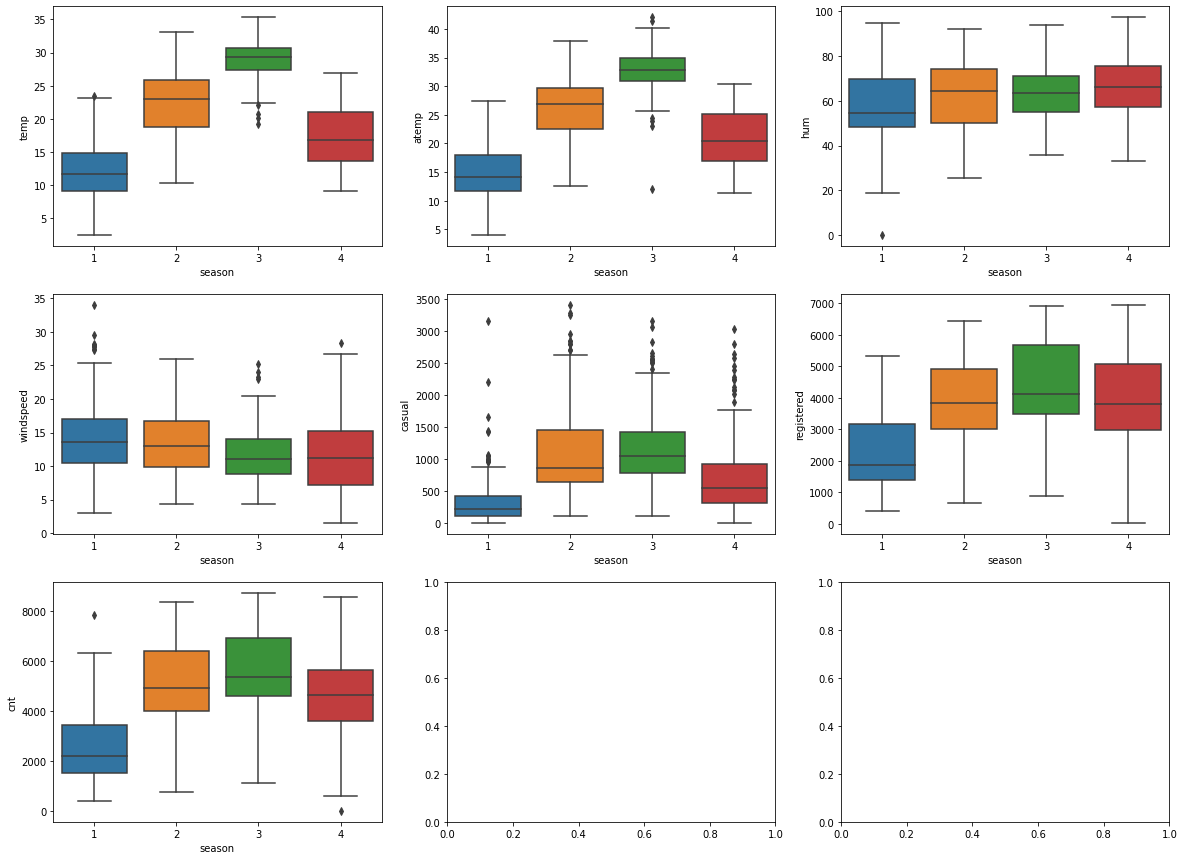

In [140]:
# Checking for outliers
test = ['temp', 'atemp', 'hum', 'windspeed','casual', 'registered', 'cnt']
fig,ax1 = plt.subplots(3,3,figsize = (20,15))
for i, number in enumerate(test):
    sns.boxplot(x = 'season',y = number, ax=ax1[i//3, i%3],data=df)

We dont need to remove outliers because there are only outliers in casual column which wont really affect findings.

# Weather Dataset

In [141]:
df_weather.columns

Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')

In [142]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [143]:
# convert fahrenheit to celcius
df_weather['AvgTemperature'] = (df_weather['AvgTemperature'] - 32) * 0.5556

In [144]:
#combine month day year to create datetime
df_weather['Date'] = pd.to_datetime(df_weather[['Year','Month']].assign(DAY=1))

#put quarter based from newly created 'Date' Column
df_weather['Quarter'] = df_weather['Date'].dt.quarter

<AxesSubplot:xlabel='AvgTemperature', ylabel='Region'>

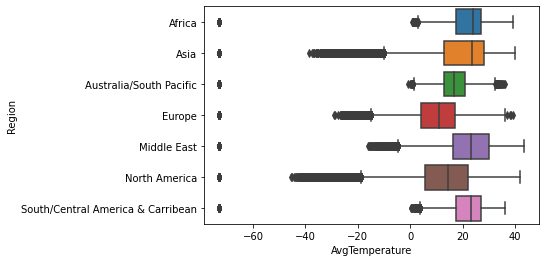

In [145]:
#removing outliers
sns.boxplot(x = 'AvgTemperature',y = 'Region',data = df_weather)

We can notice that for all regions there are temperature well below -60 degrees. We will remove this to have a better representation of the temperature data.

In [146]:
#we can see temperature less than -60, remove less than - 60
filt = df_weather[df_weather['AvgTemperature'] < -60]
df_weather.drop(filt.index, inplace = True)
print(f"The outliers from the df_weather dataset is {filt.shape[0]} rows")

The outliers from the df_weather dataset is 79672 rows


we can't remove more data because the result of the analysis won't be representing the true analysis in terms of temperature.

In [147]:
#city dataset seperate it from weather data set
df_city = pd.DataFrame(df_weather.groupby(['City','Country'])['AvgTemperature'].median())
df_city.rename(columns = {'AvgTemperature':'CityMedTemperature'}, inplace = True)

Create a new dataset called df_city where it would contain the quarterly temperature of each countries and cities. We would be using the median temperature instead of the mean in order to have a better representation of the temperature.

In [148]:
# set each quarter of the city and country to a variable 
firstq_city = df_weather.groupby('Quarter').get_group(1).groupby(['City','Country'])['AvgTemperature'].median()
secondq_city = df_weather.groupby('Quarter').get_group(2).groupby(['City','Country'])['AvgTemperature'].median()
thirdq_city = df_weather.groupby('Quarter').get_group(3).groupby(['City','Country'])['AvgTemperature'].median()
fourthq_city = df_weather.groupby('Quarter').get_group(4).groupby(['City','Country'])['AvgTemperature'].median()

# add those to newly made df_city
df_city['firstq_city'] = firstq_city
df_city['secondq_city'] = secondq_city
df_city['thirdq_city'] = thirdq_city
df_city['fourthq_city'] = fourthq_city
df_city.sort_values('Country',inplace = True)
df_city

,,CityMedTemperature,firstq_city,secondq_city,thirdq_city,fourthq_city
City,Country,,,,,
Tirana,Albania,15.94572,9.27852,18.72372,24.55752,12.72324
Algiers,Algeria,17.50140,11.77872,18.94596,25.44648,15.27900
Buenos Aires,Argentina,17.39028,22.94628,13.89000,11.88984,19.83492
Perth,Australia,17.89032,23.94636,16.05684,13.38996,19.66824
Melbourne,Australia,18.66816,22.66848,16.22352,14.16780,20.33496
...,...,...,...,...,...,...
Tashkent,Uzbekistan,16.55688,5.88936,22.55736,27.16884,8.66736
Caracas,Venezuela,27.27996,26.11320,27.44664,28.16892,27.39108
Hanoi,Vietnam,25.39092,18.89040,27.61332,28.61340,22.50180


# Population Dataset

In [149]:
df_city_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city_name   41001 non-null  object 
 1   latitude    41001 non-null  float64
 2   longitude   41001 non-null  float64
 3   country     41001 non-null  object 
 4   population  40263 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


In [150]:
# rename city column
df_city_population.rename(columns = {'city_name ':'City','country':'Country'}, inplace = True)

# only get needed columns in df_city_population
df_city_population = df_city_population[['City','population']]

In [151]:
#join df_city_population and df_city
df_city = df_city.reset_index().set_index('City').join(df_city_population.set_index('City'))

In [152]:
df_city.head()

,Country,CityMedTemperature,firstq_city,secondq_city,thirdq_city,fourthq_city,population
City,,,,,,,
Abidjan,Ivory Coast,27.00216,28.00224,27.55776,25.11312,27.27996,4980000.0
Abilene,US,19.22376,10.33416,23.16852,27.66888,13.50108,123420.0
Abilene,US,19.22376,10.33416,23.16852,27.66888,13.50108,6390.0
Abu Dhabi,United Arab Emirates,29.16900,20.61276,31.89144,35.00280,25.27980,1000000.0
Addis Ababa,Ethiopia,17.00136,17.83476,18.39036,15.94572,16.61244,3041002.0


# GDP per Capita Dataset

In [153]:
#get number of columns
len(df_population.columns)

50

This dataset has plenty of columns so I refrained from displaying it, but rather I'd just get the needed columns from this dataset.

In [154]:
#just get useful columns from population data set
df_population = pd.DataFrame([df_population['country'],df_population['GDP per capita (current US$)']]).T
df_population.rename(columns = {'GDP per capita (current US$)':'GDP_capita'}, inplace = True)

In [155]:
df_population.head()

,country,GDP_capita
0,Afghanistan,623.2
1,Albania,3984.2
2,Algeria,4154.1
3,American Samoa,-99.0
4,Andorra,39896.4


In [156]:
#change the name of United States of America to US
df_population['country'].replace({'United States of America':'US'}, inplace = True)

<AxesSubplot:xlabel='GDP_capita'>

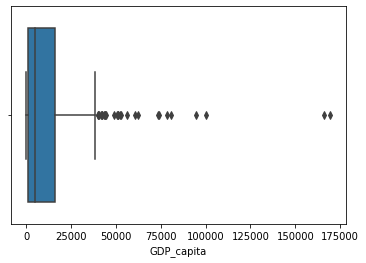

In [157]:
#check outliers
sns.boxplot(x = 'GDP_capita',data = df_population)

In [158]:
# add gdp per capita in df_city and combine df_city and df_population
df_city = df_city.reset_index().set_index('Country').join(df_population.set_index('country'))

In [159]:
#change column name 'index' to 'country' and reset index
df_city.reset_index(inplace = True)
df_city.rename(columns = {'index':'Country'}, inplace = True)

# Exploratory Data Analysis

Let us first find out if there are any correlation between casual/registered users and seasons/months.

<AxesSubplot:xlabel='mnth', ylabel='registered'>

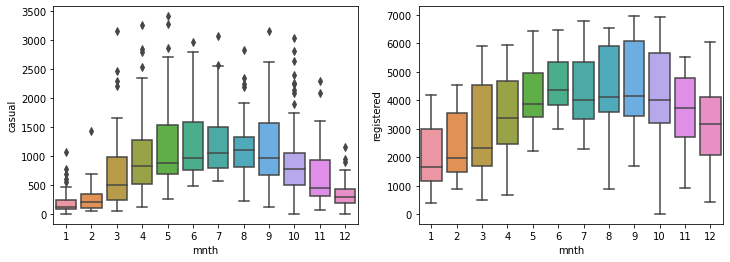

In [160]:
# graph for monthly users
fig, ax =plt.subplots(1,2,figsize=(12, 4))
sns.boxplot(x = 'mnth', y = df['casual'], ax=ax[0], data = df)
sns.boxplot(x = 'mnth', y = df['registered'], ax=ax[1], data = df)

There is a parabolic shape in users of bike rentals as months passed by with peaking on September and lowest point during January. Let's look at the association of months with weather.

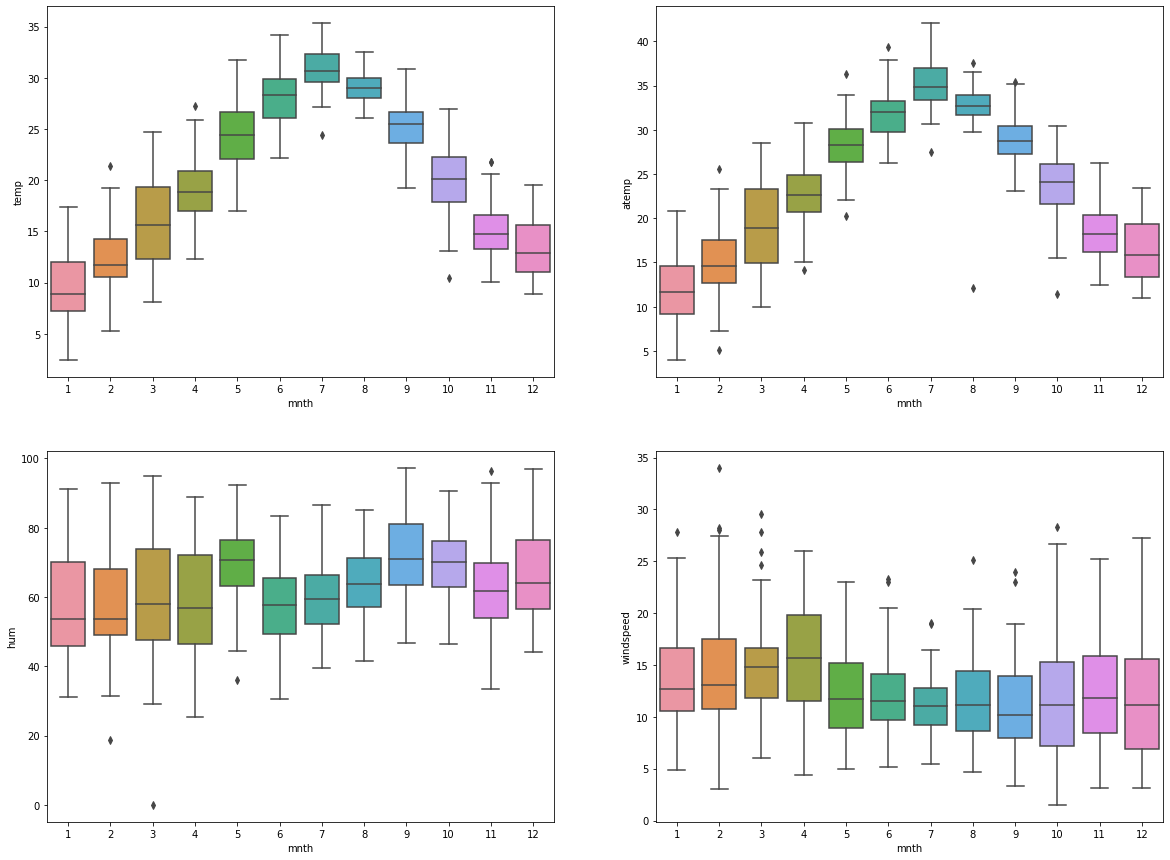

In [161]:
# associate months with weather
weather = [ 'temp', 'atemp', 'hum', 'windspeed']
fig,ax1 = plt.subplots(2,2,figsize = (20,15))
for i, number in enumerate(weather):
    sns.boxplot(x = 'mnth',y = number, ax=ax1[i//2, i%2],data=df)

Like with the parabolic shape when we saw the graph of the monthly users, the same shape could be seen when we associated months with temperature.The temperature peaks during July while the lowest temperature is during January.

<AxesSubplot:xlabel='season', ylabel='registered'>

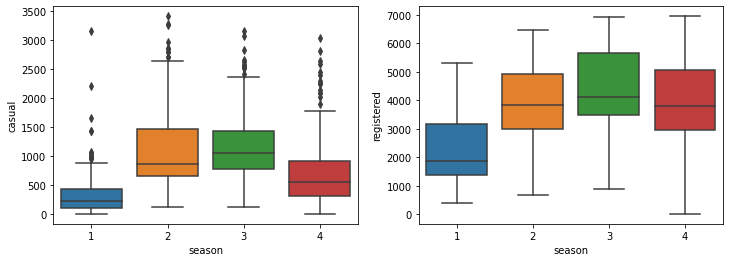

In [162]:
# graph for seasonal users
fig, ax =plt.subplots(1,2,figsize=(12, 4))
sns.boxplot(x = 'season', y = df['casual'], ax=ax[0], data = df)
sns.boxplot(x = 'season', y = df['registered'], ax=ax[1], data = df)

we could notice that casual and registered users of bike rental tends spike during summer(orange) and fall (green). But why is this the case? Let us associate seasons with weather.

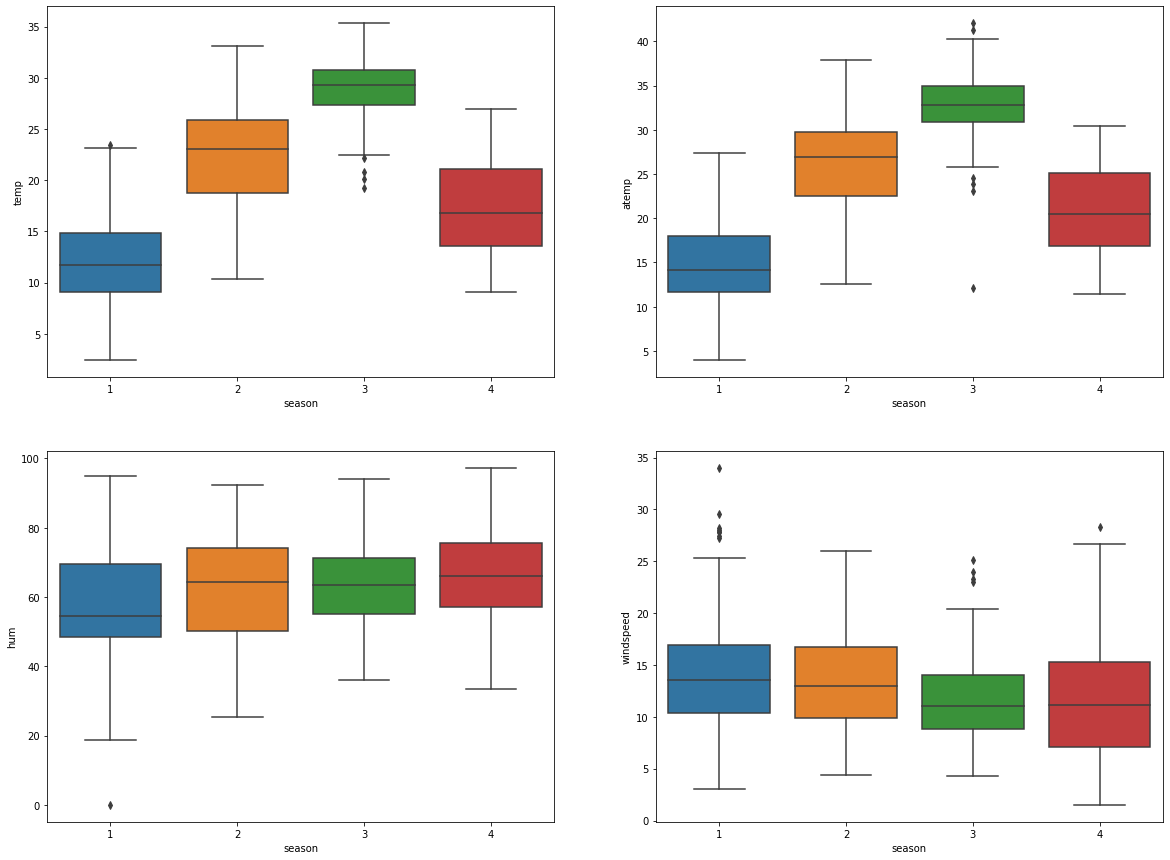

In [163]:
# associate seasons with weather
weather = [ 'temp', 'atemp', 'hum', 'windspeed']
fig,ax1 = plt.subplots(2,2,figsize = (20,15))
for i, number in enumerate(weather):
    sns.boxplot(x = 'season',y = number, ax=ax1[i//2, i%2],data=df)

The temperature and normalized felt temperature is high during summer(2) and fall(3) with its lowest in spring(1)and winter(4). 

While the humidity level is almost the same across all seasons, we can notice that summer(2) is much more spread out around its first and third quartile.

And lastly, the windspeed is almost the same with others while windspeed is lowest in fall(3) and  more spread out during winter(4).

We could notice notice that spring(1) is colder than winter(4) and fall(3) is hotter than summer(2) in this dataset. Let us find out whether this is just a naming error or if it is true.

<AxesSubplot:xlabel='temp', ylabel='Count'>

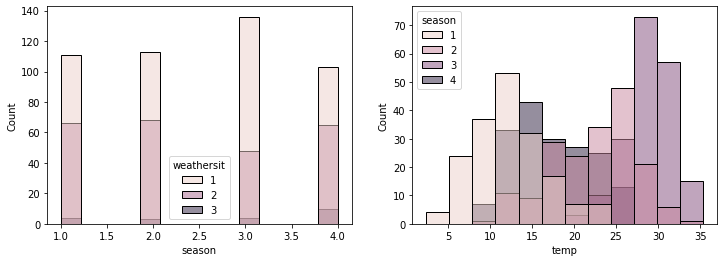

In [164]:
# graph for distribution of temperature and season
fig, ax =plt.subplots(1,2,figsize=(12, 4))
sns.histplot(x = 'season', data = df, hue = 'weathersit', ax = ax[0])
sns.histplot(x = 'temp',hue = 'season',data = df, ax = ax[1])

On the left graph which is about weathersit (state of weather), number 4 corresponds to snow + fog wherein winter(4) has the most number. On the right graph, we could see the distribution of temperature according to their seasons and we could notice that spring(1) really do has lower temperature than winter(4). 

<AxesSubplot:xlabel='mnth', ylabel='count'>

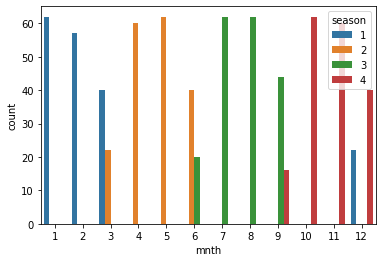

In [165]:
sns.countplot(x = 'mnth', hue = 'season', data = df)

The reason why spring is colder than winter and fall is hotter during the summer is that the categorizing of seasons isn't correct. Winter in the United States starts during the late week of december lasting up to March, but based on this data, spring(1) takes up most of it. With this in mind, we will stop referring to these as seasons but rather as quarters or by its month.

# Thoughts:
In our data set, the most suitable time to operate a bike rental business based on their temperature and number of users are during the quarters 3,2,4,1 respectively. As the first quarter isn't suitable for biking, we will consider the weather during the third, second and fourth quarter in the same order due to its close relationship with bike rental users.

# Association with weather data set

Let us find out countries and cities that are suitable for bike rental all year round.

In [166]:
# temp and atemp of season 3,2,4
#focus on 25th - 75th percentile
tmp3 = df.groupby('season')['temp'].get_group(3)
tmp2 = df.groupby('season')['temp'].get_group(2)
tmp4 = df.groupby('season')['temp'].get_group(4)
print(f"the range of the median of the 3rd quarter and fourth quarter ({tmp3.median():.4f} - {tmp4.median():.4f}) degrees celcius")

the range of the median of the 3rd quarter and fourth quarter (29.2979 - 16.7758) degrees celcius


The temperature suitable for bike rental business came from the median temperature of the third quarter(29.30 degrees) and the median temperature of the fourth quarter (16.78) which gives a temperature range of 16.78 - 29.30 degrees celcius. We would also filter out those countries that has less than the average GDP per capita and population.

In [167]:
#countries and cities that are under this temperature year round.
filt = (df_city['CityMedTemperature'] > 16.78) & (df_city['CityMedTemperature'] < 29.30) & (df_city['GDP_capita'] > df_city['GDP_capita'].mean()) & (df_city['population'] > df_city['population'].mean())
cities = df_city[filt].sort_values(['GDP_capita','population'],ascending = [False, False])
print(f"There are a total of {len(cities['Country'].unique())} Countries that has suitable weather for biking, has enough GDP per capita and population")
print(f"There are a total of {cities.shape[0]} cities that has suitable weather for biking, has enough GDP per capita and population")

There are a total of 4 Countries that has suitable weather for biking, has enough GDP per capita and population
There are a total of 17 cities that has suitable weather for biking, has enough GDP per capita and population


Text(0.5, 1.0, 'Number of Cities per Country')

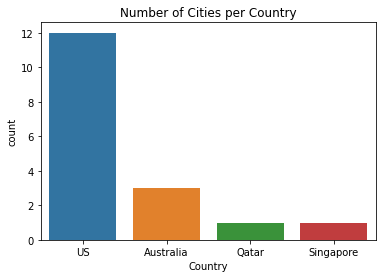

In [168]:
# count plot of number of cities in each country
df1 = pd.DataFrame(cities)
sns.countplot(x = 'Country', data = df1, order = df1['Country'].value_counts().index)
plt.title("Number of Cities per Country")

Text(0.5, 1.0, 'GDP per Capita of Qualified Countries')

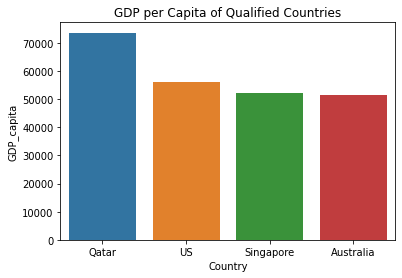

In [169]:
#graph gdp per capita of qualified countries
sns.barplot(x = 'Country', y = 'GDP_capita', data = df1)
plt.title("GDP per Capita of Qualified Countries")

There are only four suitable countries that passed the temperature,gdp, population test, those countries are  Qatar,USA,Singapore,and Australia. The mean population of each city is 1256180 people. USA has the most number of cities with 12, Australia has 3, qatar and singapore each has one.

<AxesSubplot:title={'center':'Suitable Cities for Biking Rental Business'}, xlabel='population', ylabel='City'>

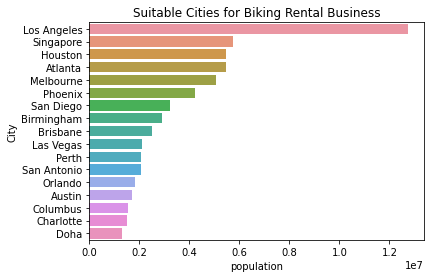

In [170]:
# order of most suitable cities for biking
plt.title("Suitable Cities for Biking Rental Business")
sns.barplot(y = 'City', x = 'population', data = df1.sort_values('population', ascending = False))

Based on this graph, opening our bike rental business in these 15 cities primarily lead by Los Angeles, Singapore, Houston, Atlanta, and Melbourne would provide the best chance of our business succeeding due to its economical landscape, number of people in the city and its weather.

# Conclusion
1. The popularity of using bikes as the people's main source of transportation is based on the weather of the country.
2. Countries such as the United States of America, Singapore, Australia, and Qatar 
